In this notebook we simulate future stock prices, risk-free rates, 3 year bonds and sharpe ratios from 31 october 2014 to 31 october 2033. We assume that the voatility follows stockastic process (Heston Model). We assume that other 

## Libraries

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Market Simulation Code

$
\begin{cases}
r_{t+dt} = r_t + \kappa_r (\bar{lt_r} - r_t) dt + \sigma_r \sqrt{dt} Z_t^r\\
SR_{t+dt} = SR_t + \kappa_sr (\bar{lt_sr} - SR_t) dt + \sigma_SR \sqrt{dt} Z_t^SR\\
V_{t+dt} = V_t + \kappa_v (lt_V - V_t) dt + \sigma_V \sqrt{V_t} \sqrt{dt} Z_t^V\\
S_{t+dt} = S_t \times \exp \left( \left( r + \bar{\lambda_0} \sigma_t - \frac{1}{2} \sigma_t^2 \right) dt + \sigma_t \sqrt{dt} Z_t^S \right) \\
\end{cases}
$

In [318]:
def market_simulation(
    # Basic notations
    T,        # Total time in years for the simulation
    N,        # Number of discrete time steps; e.g., 252 for "trading days" in a year
    M,        # Number of simulation paths (scenarios)
    seed=123, # Random seed for reproducibility
    
    # Initial conditions
    S0=1,         # Initial stock price
    r0=0.0306,    # Initial short rate
    sr0=0.4,      # Initial Sharpe ratio
    v0=(0.2138)**2, # Initial variance (square of initial volatility)
    
    # Short-rate (Vasicek) model parameters
    lt_r=0.0306,    # Long-term mean (b in Vasicek) to which r reverts
    kappa_r=0.13,   # Mean-reversion speed for short rate
    sigma_r=0.98/100, # Volatility (std dev) of short rate’s diffusion
    
    # Sharpe-ratio (Ornstein–Uhlenbeck type) model parameters
    lt_sr=0.4,     # Long-term mean Sharpe ratio
    kappa_sr=0.35, # Mean-reversion speed for Sharpe ratio
    sigma_sr=0.2322, # Volatility (std dev) of Sharpe ratio process
    
    # Variance (Heston-like) model parameters
    kappa_variance=5.07,  # Mean-reversion speed of variance process
    lt_variance=(0.2138)**2, # Long-term mean of variance process
    sigma_variance=0.48,  # Vol of vol (volatility of variance process)
    
    # Correlations for covariance matrix
    # (Z is 4D, representing Brownian increments for: stock, variance, Sharpe ratio, short rate)
    rho_stock_volatility=-0.767, # Corr( dW_stock, dW_vol ) 
    rho_stock_sr=-0.2,           # Corr( dW_stock, dW_sr   )
    rho_volatility_sr=+0.767          # Corr( dW_vol,   dW_sr   )
):
    """
    Simulates multiple paths (M scenarios) of four stochastic processes over (N+1) time points:
      1. Stock price (S) following a log-Euler scheme with drift = (r + SR*sqrt(v) - 0.5*v)
      2. Variance (v) in a mean-reverting "Heston-like" process
      3. Sharpe ratio (sr) in an OU-style mean-reverting process
      4. Short rate (r) in a standard Vasicek model

    Underlying time steps: T (years) / N steps => dt = T/N

    The correlations among the Brownian increments are given by 'cov'.

    Parameters
    ----------
    T : float
        Total simulation horizon in years.
    N : int
        Number of discrete time steps.
    M : int
        Number of simulation paths/scenarios.
    seed : int, optional
        Random seed for reproducibility. Default = 123.
    S0 : float, optional
        Initial stock price.
    r0 : float, optional
        Initial short rate.
    sr0 : float, optional
        Initial Sharpe ratio.
    v0 : float, optional
        Initial variance. (Square of initial volatility)
    lt_r : float, optional
        Long-term mean for Vasicek short rate.
    kappa_r : float, optional
        Mean-reversion speed for short rate.
    sigma_r : float, optional
        Volatility parameter for short rate.
    lt_sr : float, optional
        Long-term mean for Sharpe ratio.
    kappa_sr : float, optional
        Mean-reversion speed for Sharpe ratio.
    sigma_sr : float, optional
        Volatility parameter for Sharpe ratio.
    kappa_variance : float, optional
        Mean-reversion speed for the variance process.
    lt_variance : float, optional
        Long-term mean for the variance process.
    sigma_variance : float, optional
        Volatility of the variance process (aka vol-of-vol).
    rho_stock_volatility : float, optional
        Correlation between the stock’s Brownian increment and the variance’s Brownian increment.
    rho_stock_sr : float, optional
        Correlation between the stock’s Brownian increment and the Sharpe ratio’s Brownian increment.
    rho_volatility_sr : float, optional
        Correlation between the variance’s Brownian increment and the Sharpe ratio’s Brownian increment.

    Returns
    -------
    (S, v, sr, r) : tuple of np.ndarray
        Each is an array of shape ((N+1), M):
            S[i, :] -> stock price at time step i for each of the M paths
            v[i, :] -> variance at time step i
            sr[i, :] -> Sharpe ratio at time step i
            r[i, :] -> short rate at time step i

    Notes
    -----
    - The code uses an exponential Euler scheme for the stock price: 
        S_{t+1} = S_t * exp( (r_t + sr_t * sqrt(v_t) - 0.5*v_t)*dt + sqrt(v_t*dt)*Z_{t,0} )
      This is a mix of a risk-free rate + Sharpe ratio drift approach. 
      (Under a strict risk-neutral Heston, you'd typically have just r_t - 0.5*v_t).
    - The variance v follows a mean-reverting square-root process (though not exactly the classic Heston if we omit the sqrt(v) in the drift).
    - The Sharpe ratio sr is an OU process with speed kappa_sr, mean lt_sr, vol sigma_sr.
    - The short rate r is a Vasicek process with speed kappa_r, mean lt_r, vol sigma_r.
    - The correlation matrix has 4 dimensions: [dW_stock, dW_vol, dW_sr, dW_r].
      We set Corr( dW_r, anything ) = 0 here. 
      If the final matrix is not positive semi-definite, you may get a runtime warning or numeric issues.

    Example usage:
    -------------
    S, v, sr, r = market_simulation(
        T=1.0, N=252, M=10000, seed=42,
        rho_stock_volatility=-0.7, rho_stock_sr=-0.2
    )
    """

    # Time step size in years
    dt = T / N
    
    # Mean (0-vector) and covariance matrix for Brownian increments
    mu = np.array([0, 0, 0, 0])
    cov = np.array([
        [1,                    rho_stock_volatility,  rho_stock_sr,     0],
        [rho_stock_volatility, 1,                     rho_volatility_sr,0],
        [rho_stock_sr,         rho_volatility_sr,     1,                0],
        [0,                    0,                     0,                1]
    ])

    # Initialize paths
    # (N+1) time points (including t=0), M scenarios
    S = np.full(shape=(N+1, M), fill_value=S0)  # stock
    v = np.full(shape=(N+1, M), fill_value=v0)  # variance
    sr = np.full(shape=(N+1, M), fill_value=sr0)# Sharpe ratio
    r = np.full(shape=(N+1, M), fill_value=r0)  # short rate
    
    # Draw correlated Brownian increments (Z) under the chosen measure
    # Z.shape = (N, M, 4) => For each time step, we have M sets of 4 correlated draws
    np.random.seed(seed)
    Z = np.random.multivariate_normal(mu, cov, size=(N, M))

    # Main simulation loop
    for i in range(1, N+1):
        # For notation convenience:
        #   i-1: previous time index
        #   Z[i-1,:,0]: Brownian increments for the stock
        #   Z[i-1,:,1]: Brownian increments for the variance
        #   Z[i-1,:,2]: Brownian increments for the Sharpe ratio
        #   Z[i-1,:,3]: Brownian increments for the short rate
        
        # -- Update Stock Price (exponential Euler) --
        S[i] = S[i-1] * np.exp(
            (r[i-1] + sr[i-1] * np.sqrt(v[i-1]) - 0.5*v[i-1]) * dt
            + np.sqrt(v[i-1] * dt) * Z[i-1,:,0]
        )
        
        # -- Update Variance (Heston-like mean reverting) --
        v[i] = (v[i-1]
                + kappa_variance * (lt_variance - v[i-1]) * dt
                + sigma_variance * np.sqrt(v[i-1]) * np.sqrt(dt) * Z[i-1,:,1])
        
        # Enforce non-negative variance
        v[i] = np.maximum(v[i], 0)
        
        # -- Update Sharpe Ratio (OU process) --
        sr[i] = (sr[i-1]
                 + kappa_sr*(lt_sr - sr[i-1]) * dt
                 + sigma_sr * np.sqrt(dt) * Z[i-1,:,2])

        # -- Update Short Rate (Vasicek) --
        r[i] = (r[i-1]
                + kappa_r*(lt_r - r[i-1]) * dt
                + sigma_r * np.sqrt(dt) * Z[i-1,:,3])

    # Optional: Quick diagnostic check
    if np.sum(v < 0) > 0:
        print("Warning! Some variance values became negative (after truncation).")
        
    S = pd.DataFrame(S, index = np.linspace(0,T, len(S)))
    v = pd.DataFrame(v, index = np.linspace(0,T, len(S)))
    sr =pd.DataFrame(sr, index = np.linspace(0,T, len(S)))
    r = pd.DataFrame(r, index = np.linspace(0,T, len(S)))
    return S, v, sr, r


In [319]:
# Parameters
S0 = 100.0              # asset price
T = 30                 # time in years
N = 252*30              # number of time steps in simulation
M = 10                  # number of simulated paths
seed = 123              # simulation seed

In [320]:
# Suppose you have these arrays (each is shape (N+1, M) for N+1 time steps, M paths):
# S_p (Heston asset log-prices),
# v_p (Heston variance process),
# sr_p (Sharpe ratio process),
# r_p (Vasicek interest-rate process)

S_p, v_p, sr_p, r_p = market_simulation(T, N, M,seed,S0)
time = np.linspace(0, T, N+1)

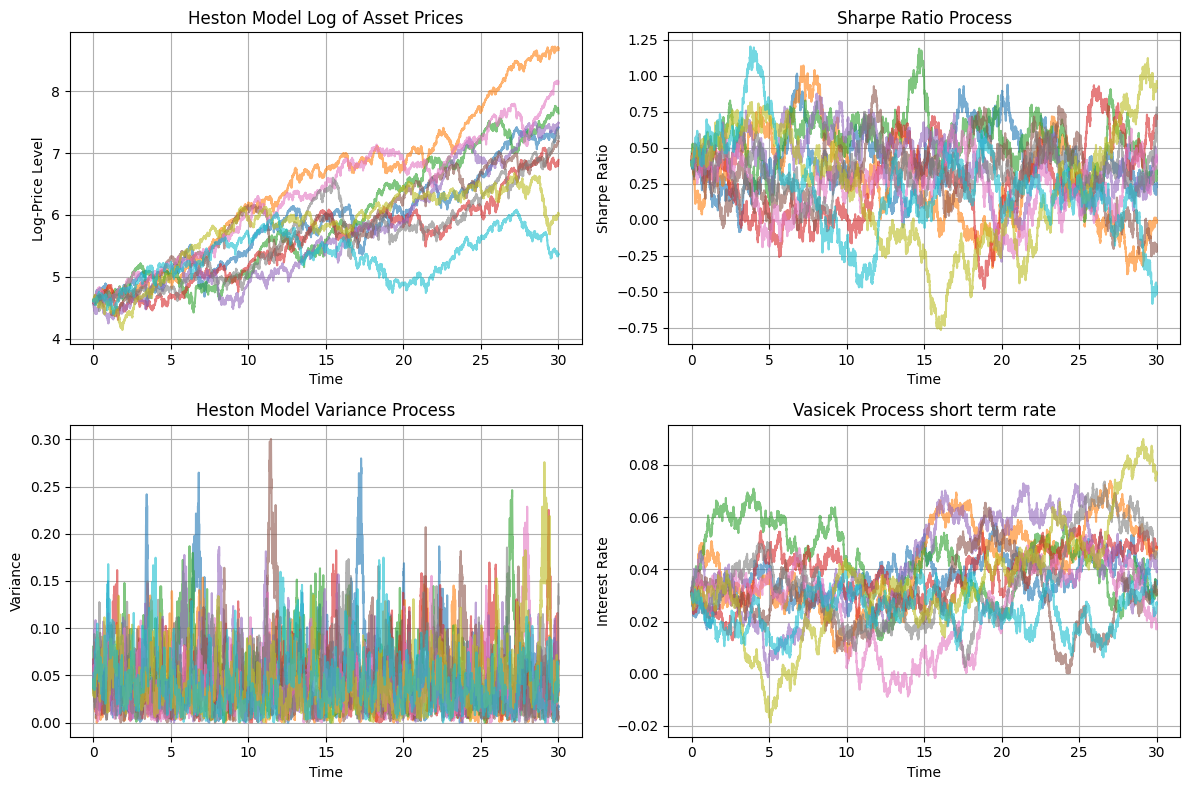

In [321]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- (1) Heston Model log of Asset Prices ---
axes[0, 0].plot(time, np.log(S_p), alpha=0.6)
axes[0, 0].set_title("Heston Model Log of Asset Prices")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Log-Price Level")
axes[0, 0].grid(True)

# --- (2) Heston Model Variance Process ---
axes[1, 0].plot(time, v_p, alpha=0.6)
axes[1, 0].set_title("Heston Model Variance Process")
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Variance")
axes[1, 0].grid(True)

# --- (3) Sharpe Ratio Process ---
axes[0, 1].plot(time, sr_p, alpha=0.6)
axes[0, 1].set_title("Sharpe Ratio Process")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Sharpe Ratio")
axes[0, 1].grid(True)

# --- (4) Vasicek Process (Interest Rate) ---
axes[1, 1].plot(time, r_p, alpha=0.6)
axes[1, 1].set_title("Vasicek Process short term rate")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Interest Rate")
axes[1, 1].grid(True)

plt.tight_layout()

# 2. Bond simulation

In [193]:
# Function for Vasicek Zero-Coupon Bond (ZCB) Price
def vasicek_zcb_price(r_t, tau=3, kappa_r=0.13, lt_r=0.0306, sigma_r=0.015):
    """
    Computes the price P(t, t+tau) of a zero-coupon bond under the Vasicek model.

    Parameters:
    - r_t: Short rate at time t
    - tau: Time to maturity in years (default = 3 years)
    - kappa_r: Mean reversion speed of the short rate process
    - lt_r: Long-term mean interest rate (theta in Vasicek model)
    - sigma_r: Volatility of interest rate

    Returns:
    - Price of the zero-coupon bond P(t, t+tau)
    """
    
    # Compute B(t, T) factor in Vasicek model
    B = (1.0 - np.exp(-kappa_r * tau)) / kappa_r

    # Compute A(t, T) factor in Vasicek model
    A_term1 = (lt_r - (sigma_r**2) / (2.0 * kappa_r**2)) * (B - tau)
    A_term2 = (sigma_r**2) / (4.0 * kappa_r) * B**2
    A = A_term1 - A_term2

    # Compute bond price using Vasicek formula
    return np.exp(-A - B * r_t)

In [310]:
def deduce_bond_index(zero_coupon_prices, r_p, dt, initial_investment=100):
    """
    Computes a constant maturity bond index based on zero-coupon bond prices and short-term interest rates.

    Parameters:
    zero_coupon_prices (DataFrame): Zero-coupon bond prices for different maturities over time.
    r_p (Series or DataFrame): Short-term interest rates (or bond yields).
    dt (float): Time step size.
    initial_investment (float, optional): Initial investment amount. Default is 100.

    Returns:
    DataFrame: Computed bond index values.
    """
    
    # Compute the return from changes in zero-coupon bond prices
    return_from_change_in_bond_price = zero_coupon_prices.pct_change().fillna(0)

    # Include the dt factor explicitly
    return_from_coupons = r_p * dt  # Keeps dt in formula

    # Compute total return index
    index_return = return_from_coupons + return_from_change_in_bond_price

    # Compute bond index, scaling by initial investment
    bond_index = initial_investment * (index_return+1).cumprod()

    return bond_index

In [311]:
zero_coupon_3_y_prices = vasicek_zcb_price(r_p)
bond_index_3y = deduce_bond_index(zero_coupon_3_y_prices, r_p, dt = 1/252)

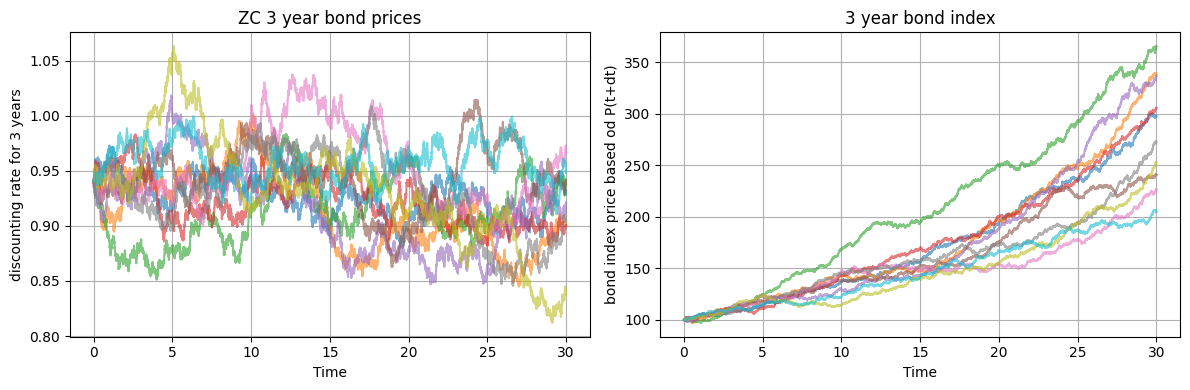

In [312]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(zero_coupon_3_y_prices, alpha = 0.6);
axes[0].set_title("ZC 3 year bond prices")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("discounting rate for 3 years")
axes[0].grid(True)

axes[1].plot(bond_index_3y, alpha = 0.6);
axes[1].set_title("3 year bond index")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("bond index price based od P(t+dt)")
axes[1].grid(True)

plt.tight_layout()

We can try to simulate 11 year bond, 12 year bonds, etc. to match our duture essential cash flows. Then check the present value distribution that might be needed.

In [291]:
import retirement_api as rt
payments_of_25k = rt.generate_equal_consumption_streams(cash_flows_decumulation=-25000, inflation_rate=0.02)
payments_of_25k['inflation_adjusted_CFs']

1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11   -31084.357710
12   -31706.044864
13   -32340.165761
14   -32986.969077
15   -33646.708458
16   -34319.642627
17   -35006.035480
18   -35706.156189
19   -36420.279313
20   -37148.684899
21   -37891.658597
22   -38649.491769
23   -39422.481605
24   -40210.931237
25   -41015.149862
26   -41835.452859
27   -42672.161916
28   -43525.605154
29   -44396.117257
30   -45284.039603
Name: inflation_adjusted_CFs, dtype: float64